<h1><center>Airline Fare Prediction Project</center></h1>

<div>
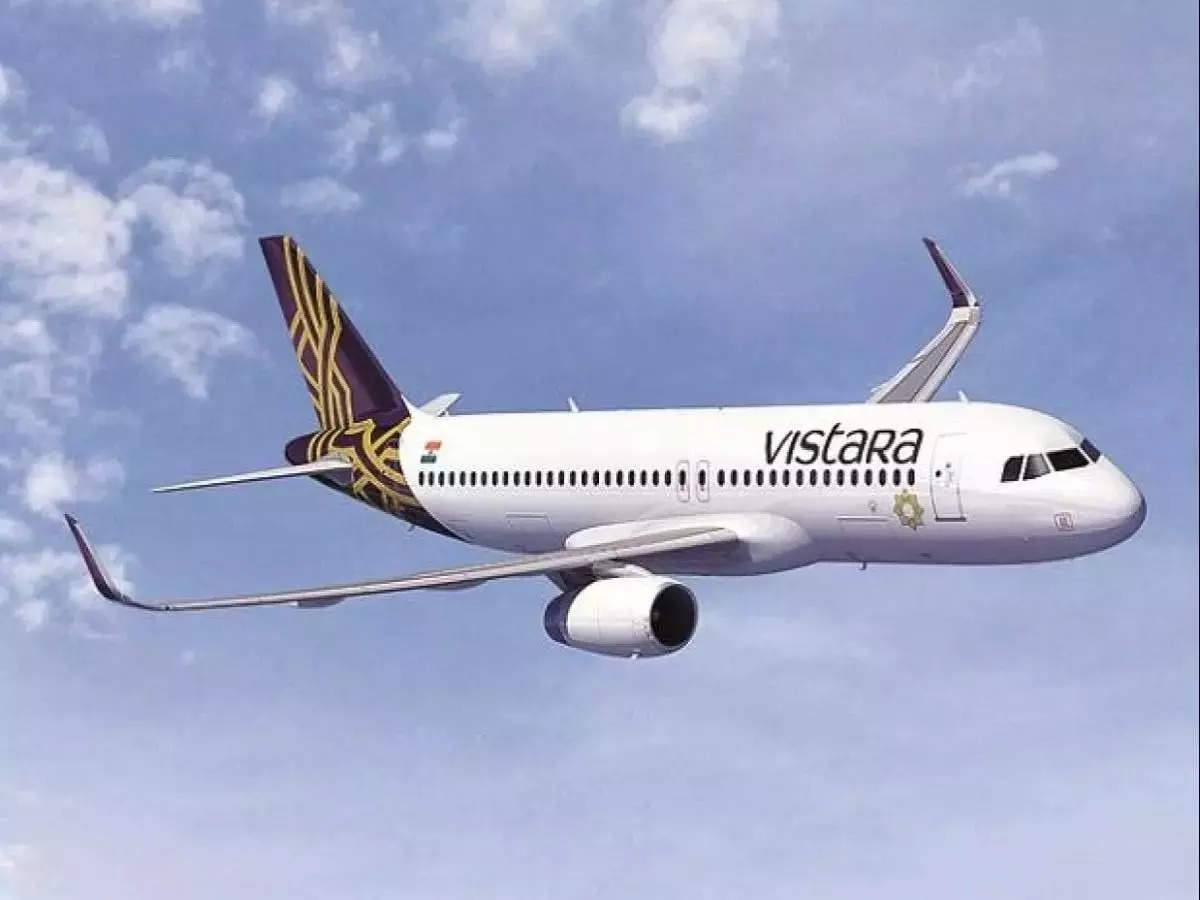
</div>


<p><justify> In this project we are going to predict the price of flight tickets from Vistara airline. We carried out a comprehensive exploratory data analysis using various high-level plots from seaborn, like histplot, scatterplot and regplot. The project illustrates the use of feature scaling using scikit-learn highlighting the differences between nominal and ordinal categorical features. It also uses Optuna for fine-tuning the parameters of a xgboost regressor created to estimate ticket price.</justify><p>

Let's first import all the necessary libraries

In [1]:
import pandas as pd                             
import numpy as np                             
import seaborn as sns                           
import matplotlib.pyplot as plt                 
import optuna                                   
import joblib                                   

from sklearn.feature_selection import mutual_info_regression         
from sklearn.model_selection import train_test_split,KFold          
from sklearn.metrics import mean_absolute_error,mean_squared_error   

from xgboost import XGBRegressor                                    
from sklearn.preprocessing import OneHotEncoder,OrdinalEncoder      

sns.set_style("whitegrid")
plt.style.use('fivethirtyeight')

Let's import the csv file containing Vistara data on flight fares.

In [2]:
df = pd.read_csv('Vistara.csv')
print("{} entries and {} features.".format(df.shape[0],df.shape[1]))
df.head()

127859 entries and 10 features.


,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
1,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955
2,UK-945,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.33,1,5955
3,UK-927,Delhi,Morning,zero,Morning,Mumbai,Economy,2.08,1,6060
4,UK-951,Delhi,Afternoon,zero,Evening,Mumbai,Economy,2.17,1,6060


We can now check for null values

In [4]:
df.isnull().sum()

flight              0
source_city         0
departure_time      0
stops               0
arrival_time        0
destination_city    0
class               0
duration            0
days_left           0
price               0
dtype: int64

## Exploratory Data Analysis

First let's take a look at the column properties

In [3]:
df.describe(include='all')

,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
count,127859,127859,127859,127859,127859,127859,127859,127859.000000,127859.000000,127859.000000
unique,133,6,5,3,6,6,2,NaN,NaN,NaN
top,UK-706,Mumbai,Morning,one,Night,Mumbai,Economy,NaN,NaN,NaN
freq,3235,25535,33904,111181,40693,24182,67270,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.326634,25.894532,30396.536302
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.777230,13.638537,25637.159445
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,1714.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.500000,14.000000,6412.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.500000,26.000000,15543.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.000000,38.000000,55377.000000


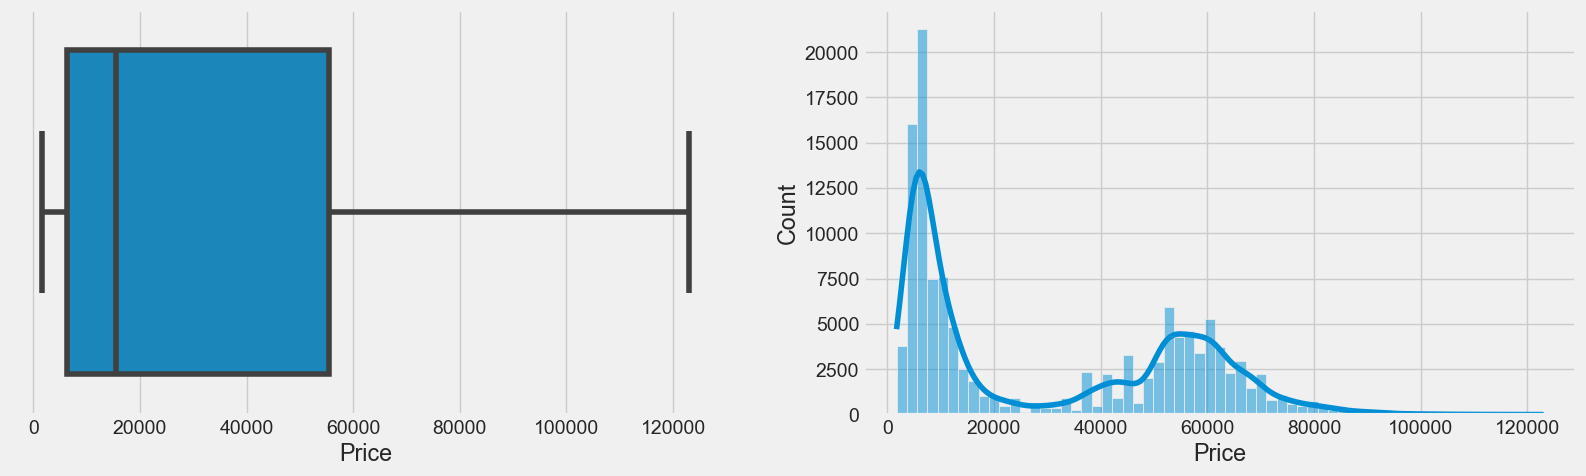

In [4]:
fig, axes = plt.subplots(1,2,figsize=(18,5))

g= sns.histplot(x = 'price', data = df, kde = True, ax = axes[1])
g.set_xlabel('Price')
g.set_ylabel('Count')
plt.subplot(1,2,1)
f = sns.boxplot(x = 'price', data = df,ax = axes[0])
f.set_xlabel('Price')
plt.show()

As we can see, the average price is approximately 30 000, however the median of the price distribution is approximately 15 000. This difference is explained by the existence of two ticket types: Business and Economy. In the second graph we clearly see that the price distribution is bimodal.

### How does the ticket price vary between Economy and Business classes?

To visualize the difference between the two ticket types, we will plot prices for Business and Economy tickets.

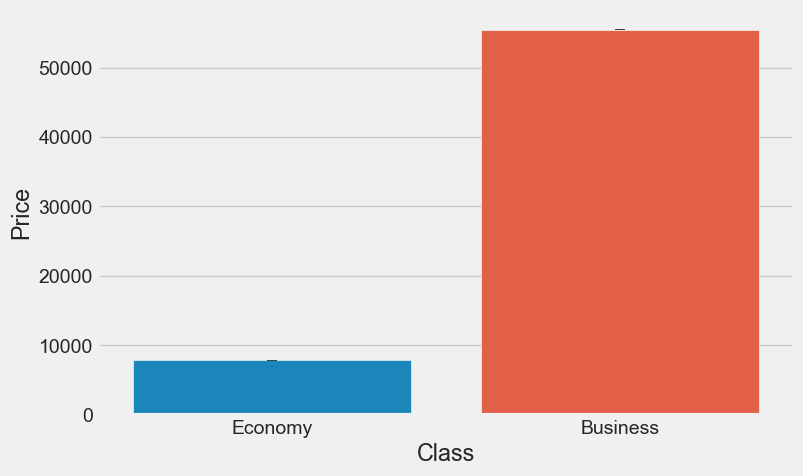

In [5]:
fig,ax = plt.subplots(figsize=(8,5))
g = sns.barplot(x='class',y='price',data=df,ax = ax)
g.set_xlabel('Class')
g.set_ylabel('Price')
plt.show()

> 📌 There is a significant price difference between both classes.

### How does the ticket price vary with the days left for the flight?

To visualize how prices change depending on the days remaining, we graph the average price as a function of days, to try to unveil a pattern in the curve.

In [6]:
df_temp = df.groupby(['days_left'])['price'].mean().reset_index()

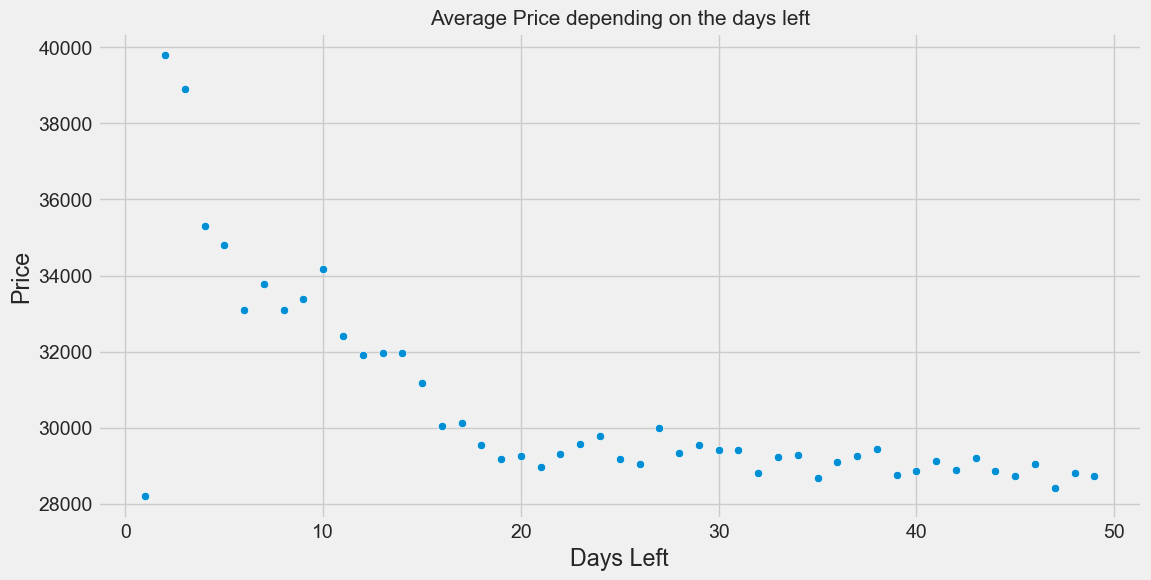

In [7]:
fig,ax = plt.subplots(figsize=(12,6))
g = sns.scatterplot(x="days_left", y="price", data=df_temp)
g.set_title("Average Price depending on the days left",fontsize=15)
g.set_xlabel('Days Left')
g.set_ylabel('Price')
plt.show()

We can observe two trends. The first trend is a monotonous decreasing curve between 2 and 20 days, which reflects the increase in ticket prices with the advent of the flight. The second shows a price plateau between 20 and 50 days before the flight.In addition we see that the day ahead of the flight, the price plummets.

In [8]:
one_day = df_temp.loc[df_temp["days_left"]==1]
two2twenty_day = df_temp.loc[(df_temp["days_left"]>1)&(df_temp["days_left"]<20)]
twenty_day = df_temp.loc[df_temp["days_left"]>=20]

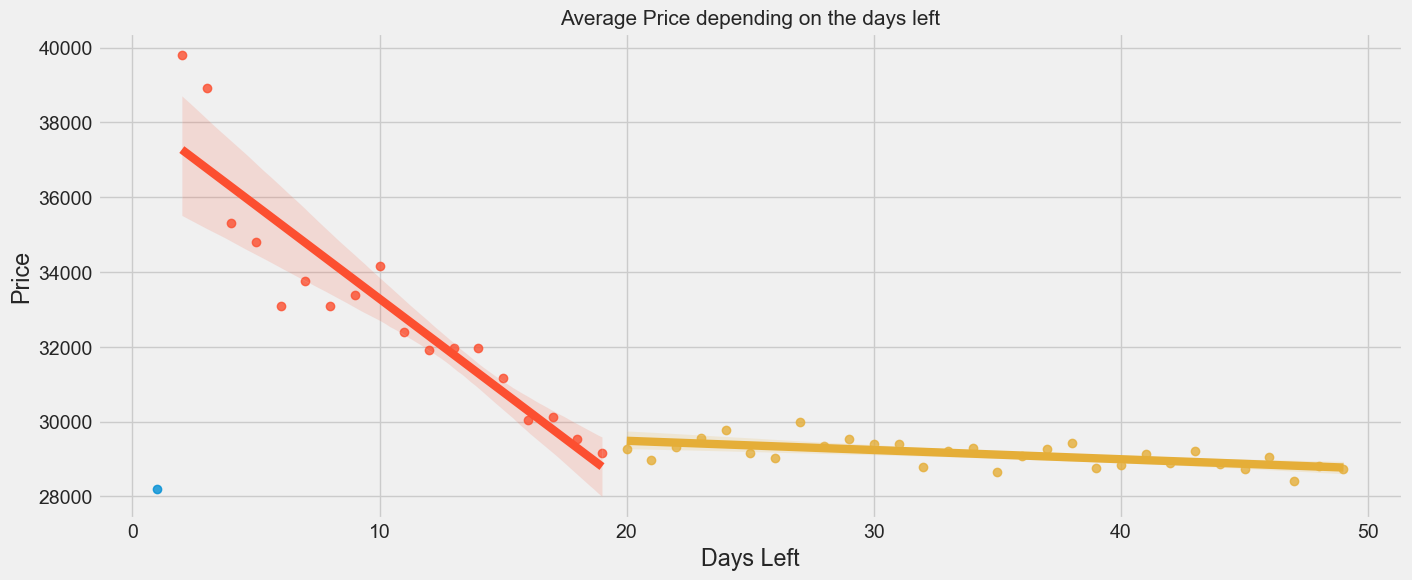

In [9]:
fig,ax = plt.subplots(figsize=(15,6))
g = sns.regplot(x=one_day['days_left'], y=one_day['price'], fit_reg=False, ax=ax)
g = sns.regplot(x=two2twenty_day['days_left'], y=two2twenty_day['price'], fit_reg=True, ax=ax)
g = sns.regplot(x=twenty_day['days_left'], y=twenty_day['price'], fit_reg=True, ax=ax)
g.set_xlabel('Days Left')
g.set_ylabel('Price')
g.set_title('Average Price depending on the days left', fontsize=15)
plt.show()

> 📌 The chart highlights how prices rise slowly and then start to rise sharply 20 days before the flight, but fall sharply again just one day before the flight. This reflects the fact that companies want to fill empty seats by lowering ticket prices to ensure planes remain full.

### How does the price change with flight duration?

Flight duration is another factor that may influence the price.

In [11]:
df_temp = df.groupby(['duration'])['price'].mean().reset_index()

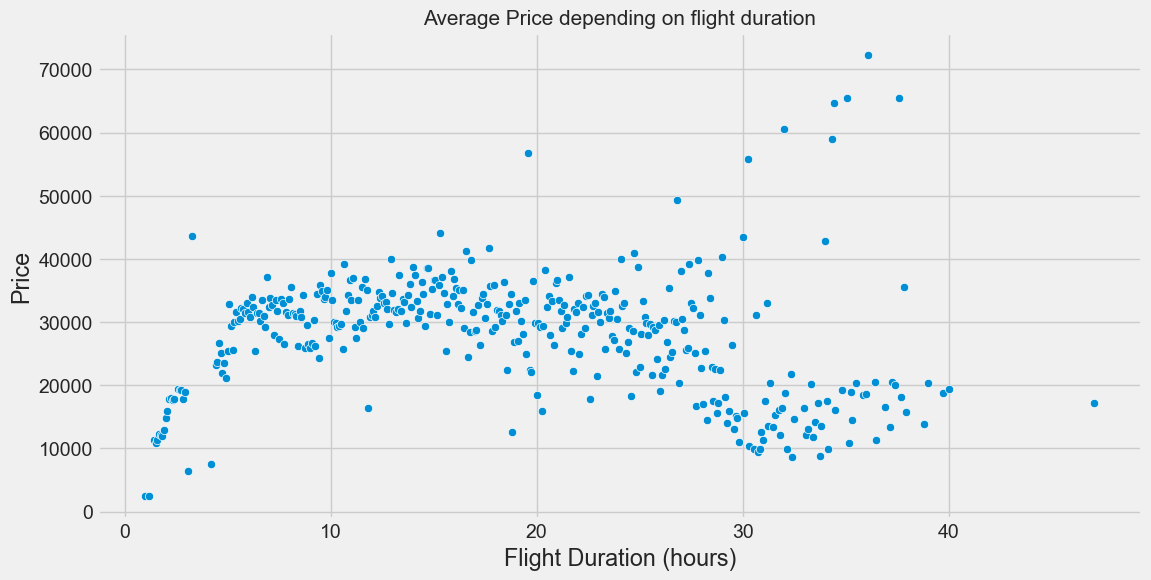

In [13]:
fig,ax = plt.subplots(figsize=(12,6))
g = sns.scatterplot(x="duration", y="price", data=df_temp, ax =ax)
g.set_title('Average Price depending on flight duration',fontsize=15)
g.set_xlabel('Flight Duration (hours)')
g.set_ylabel('Price')
plt.show()

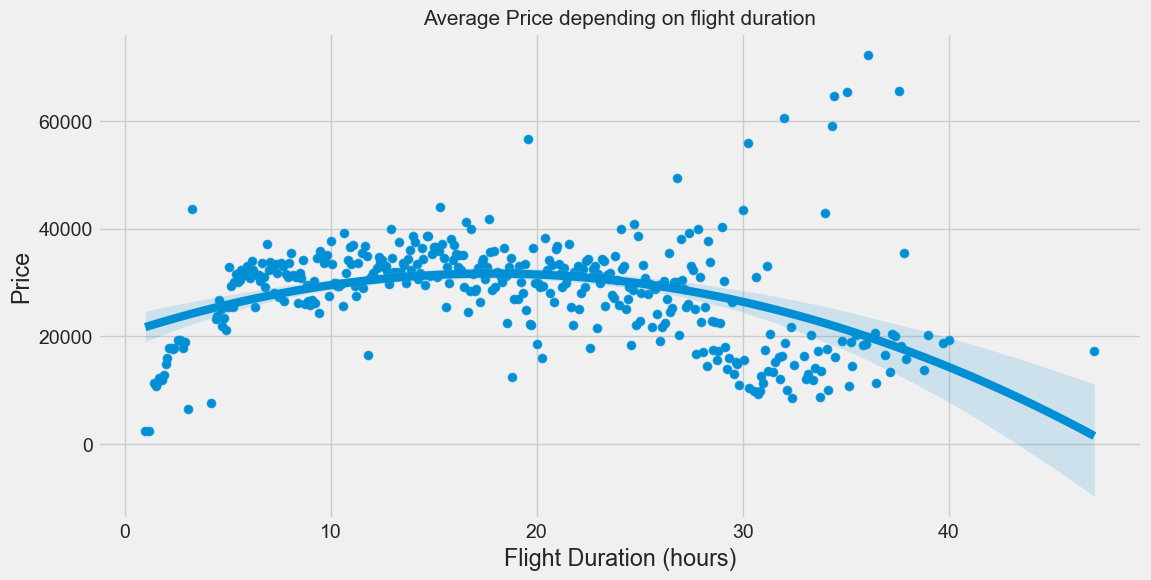

In [14]:
fig,ax = plt.subplots(figsize=(12,6))
g = sns.scatterplot(x="duration", y="price", data=df_temp, ax =ax)
g = sns.regplot(x="duration", y="price", data=df_temp, order=2, ax=ax)
g.set_title('Average Price depending on flight duration',fontsize=15)
g.set_xlabel('Flight Duration (hours)')
g.set_ylabel('Price')
plt.show()

> 📌 The relationship is not linear but can be approximated with a second degree curve. Prices reach a maximum at approximately 20 hours before falling again. However, some outliers seem influence the regression curve.

### How does the ticket price vary depending on departure time and arrival time?

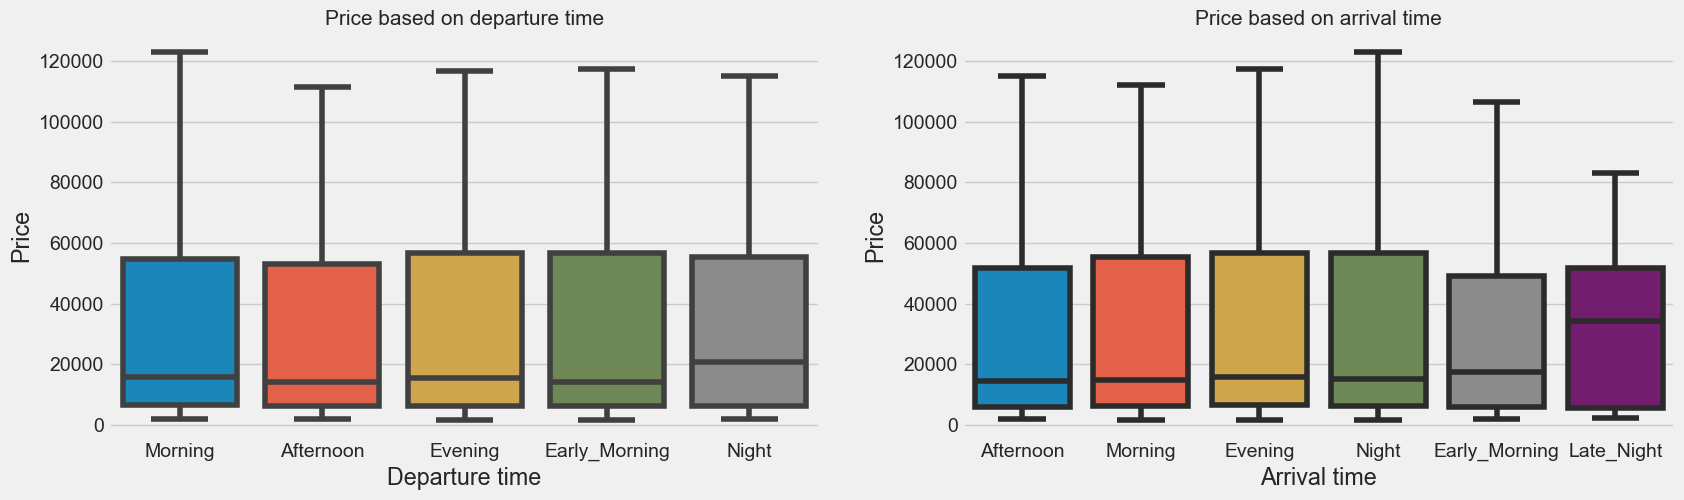

In [16]:
fig, axes = plt.subplots(1,2,figsize=(18,5))

g= sns.boxplot(data=df, y="price", x="departure_time",showfliers=False,ax = axes[0])
g.set_title("Price based on departure time",fontsize=15)
g.set_xlabel('Departure time')
g.set_ylabel('Price')
f = sns.boxplot(data=df, y="price", x="arrival_time",showfliers=False ,ax = axes[1])
f.set_title("Price based on arrival time",fontsize=15)
f.set_xlabel('Arrival time')
f.set_ylabel('Price')
plt.show()

> 📌 Quite similar but it seems that leaving at night and arriving at night is a little bit more expensive.

### How does the number of stops influence the price?

Let's see how the number of stop may influence the final price.

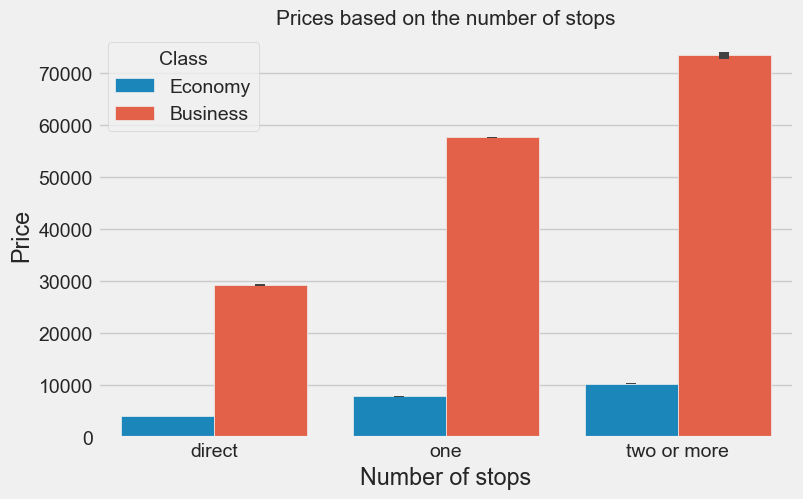

In [17]:
fig, ax = plt.subplots(figsize=(8, 5))
g = sns.barplot(y = "price", x = "stops",hue ="class", data = df, ax=ax)
g.set_title("Prices based on the number of stops",fontsize=15)
g.set_xlabel('Number of stops')
stops = ['direct', 'one', 'two or more']
g.set_xticklabels(stops)
g.set_ylabel('Price')
plt.legend(title='Class')
plt.show()

> 📌 Regardless the class, the more stopovers, the more expensive the flight is.

## Feature Engineering

**`source_city`, `stops`, `destination_city`, `class`, `departure_time`, `arrival_time` are all categorical variables.** These are divided into nominal or ordinal:
1. <span style="color: blue;">**Nominals**</span> --> Order doesn't matter --> `source_city`,`destination_city`, `class`, `departure_time`, `arrival_time` --><span style="color: green;">**OneHotEncoder**</span> 
2. <span style="color: blue;">**Ordinals**</span> --> Order matters --> `stops` --> <span style="color: green;">**OrdinalEncoder**</span> 

To encode the nominal categorical variables we create a OneHotEncoder object.

In [18]:
onehot_enc = OneHotEncoder(sparse_output=False)

In [19]:
enc_source = pd.DataFrame(onehot_enc.fit_transform(df[["source_city"]]),columns=onehot_enc.get_feature_names_out(["source_city"]),index=df.index)
enc_source

,source_city_Bangalore,source_city_Chennai,source_city_Delhi,source_city_Hyderabad,source_city_Kolkata,source_city_Mumbai
0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...
127854,0.0,1.0,0.0,0.0,0.0,0.0
127855,0.0,1.0,0.0,0.0,0.0,0.0
127856,0.0,1.0,0.0,0.0,0.0,0.0
127857,0.0,1.0,0.0,0.0,0.0,0.0


In [20]:
enc_dest = pd.DataFrame(onehot_enc.fit_transform(df[["destination_city"]]),columns=onehot_enc.get_feature_names_out(["destination_city"]),index=df.index)
enc_dest

,destination_city_Bangalore,destination_city_Chennai,destination_city_Delhi,destination_city_Hyderabad,destination_city_Kolkata,destination_city_Mumbai
0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...
127854,0.0,0.0,0.0,1.0,0.0,0.0
127855,0.0,0.0,0.0,1.0,0.0,0.0
127856,0.0,0.0,0.0,1.0,0.0,0.0
127857,0.0,0.0,0.0,1.0,0.0,0.0


In [21]:
enc_class = pd.DataFrame(onehot_enc.fit_transform(df[["class"]]),columns=onehot_enc.get_feature_names_out(["class"]),index=df.index)
enc_class

,class_Business,class_Economy
0,0.0,1.0
1,0.0,1.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0
...,...,...
127854,1.0,0.0
127855,1.0,0.0
127856,1.0,0.0
127857,1.0,0.0


In [22]:
enc_dtime = pd.DataFrame(onehot_enc.fit_transform(df[["departure_time"]]),columns=onehot_enc.get_feature_names_out(["departure_time"]),index=df.index)
enc_dtime

,departure_time_Afternoon,departure_time_Early_Morning,departure_time_Evening,departure_time_Morning,departure_time_Night
0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,1.0,0.0
4,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...
127854,0.0,0.0,0.0,1.0,0.0
127855,1.0,0.0,0.0,0.0,0.0
127856,0.0,1.0,0.0,0.0,0.0
127857,0.0,1.0,0.0,0.0,0.0


In [23]:
enc_atime = pd.DataFrame(onehot_enc.fit_transform(df[["arrival_time"]]),columns=onehot_enc.get_feature_names_out(["arrival_time"]),index=df.index)
enc_atime

,arrival_time_Afternoon,arrival_time_Early_Morning,arrival_time_Evening,arrival_time_Late_Night,arrival_time_Morning,arrival_time_Night
0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...
127854,0.0,0.0,1.0,0.0,0.0,0.0
127855,0.0,0.0,0.0,0.0,0.0,1.0
127856,0.0,0.0,0.0,0.0,0.0,1.0
127857,0.0,0.0,1.0,0.0,0.0,0.0


To encode ordinal categorical variables we create an OrdinalEncoder object. First we check that the values are in the proper order.

In [24]:
stops = list(df['stops'].unique())
stops

['zero', 'one', 'two_or_more']

In [25]:
ordinal_enc = OrdinalEncoder(categories=[stops])

In [26]:
enc_stops=pd.DataFrame(ordinal_enc.fit_transform(df[["stops"]]),columns=["n_stops"],index=df.index)
enc_stops

,n_stops
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
127854,1.0
127855,1.0
127856,1.0
127857,1.0


Now we concatenate this data with the original dataset and remove the already encoded columns. We will also remove the flight column since its only purpose is acting like a flight identifier.

In [27]:
enc_df = pd.concat([df, enc_source, enc_dest,enc_class,enc_dtime,enc_atime,enc_stops], axis = 1)

In [28]:
enc_df = enc_df.drop(['flight', 'source_city','destination_city','class','departure_time','arrival_time','stops'],axis=1)

In [29]:
enc_df.head()

,duration,days_left,price,source_city_Bangalore,source_city_Chennai,source_city_Delhi,source_city_Hyderabad,source_city_Kolkata,source_city_Mumbai,destination_city_Bangalore,...,departure_time_Evening,departure_time_Morning,departure_time_Night,arrival_time_Afternoon,arrival_time_Early_Morning,arrival_time_Evening,arrival_time_Late_Night,arrival_time_Morning,arrival_time_Night,n_stops
0,2.25,1,5955,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2.33,1,5955,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,2.33,1,5955,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2.08,1,6060,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,2.17,1,6060,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


We can define a function to perform all encoding steps.

In [30]:
def encode_df(df):
    df = df.copy()
    #Create OneHotEncoder for nominal variables
    onehot_enc = OneHotEncoder(sparse_output=False)
    #Nominal variables
    nominal_vars = ["source_city","destination_city","class","departure_time","arrival_time"]
    #Apply encoding
    enc_nom_df = pd.concat(
        [pd.DataFrame(onehot_enc.fit_transform(df[[var]]),columns=onehot_enc.get_feature_names_out([var])) for var in nominal_vars]
    ,axis=1)
    #Create OrdinalEncoder for ordinal variables
    ordinal_enc = OrdinalEncoder(categories=[paradas])
    #Apply encoding
    enc_stops=pd.DataFrame(ordinal_enc.fit_transform(df[["stops"]]),columns=["n_stops"],index=df.index)
    #Concatenate encoded variables
    enc_df = pd.concat([df, enc_nom_df,enc_stops], axis = 1)
    #Delete already encoded variables
    enc_df = enc_df.drop(['flight', 'source_city','destination_city','class','departure_time','arrival_time','stops'],axis=1)
    
    return enc_df

### What variables exert a greater influence on the price?

To visualize the linear importance of each variable we will create a correlation matrix with all the features.

In [31]:
corr = enc_df.corr()

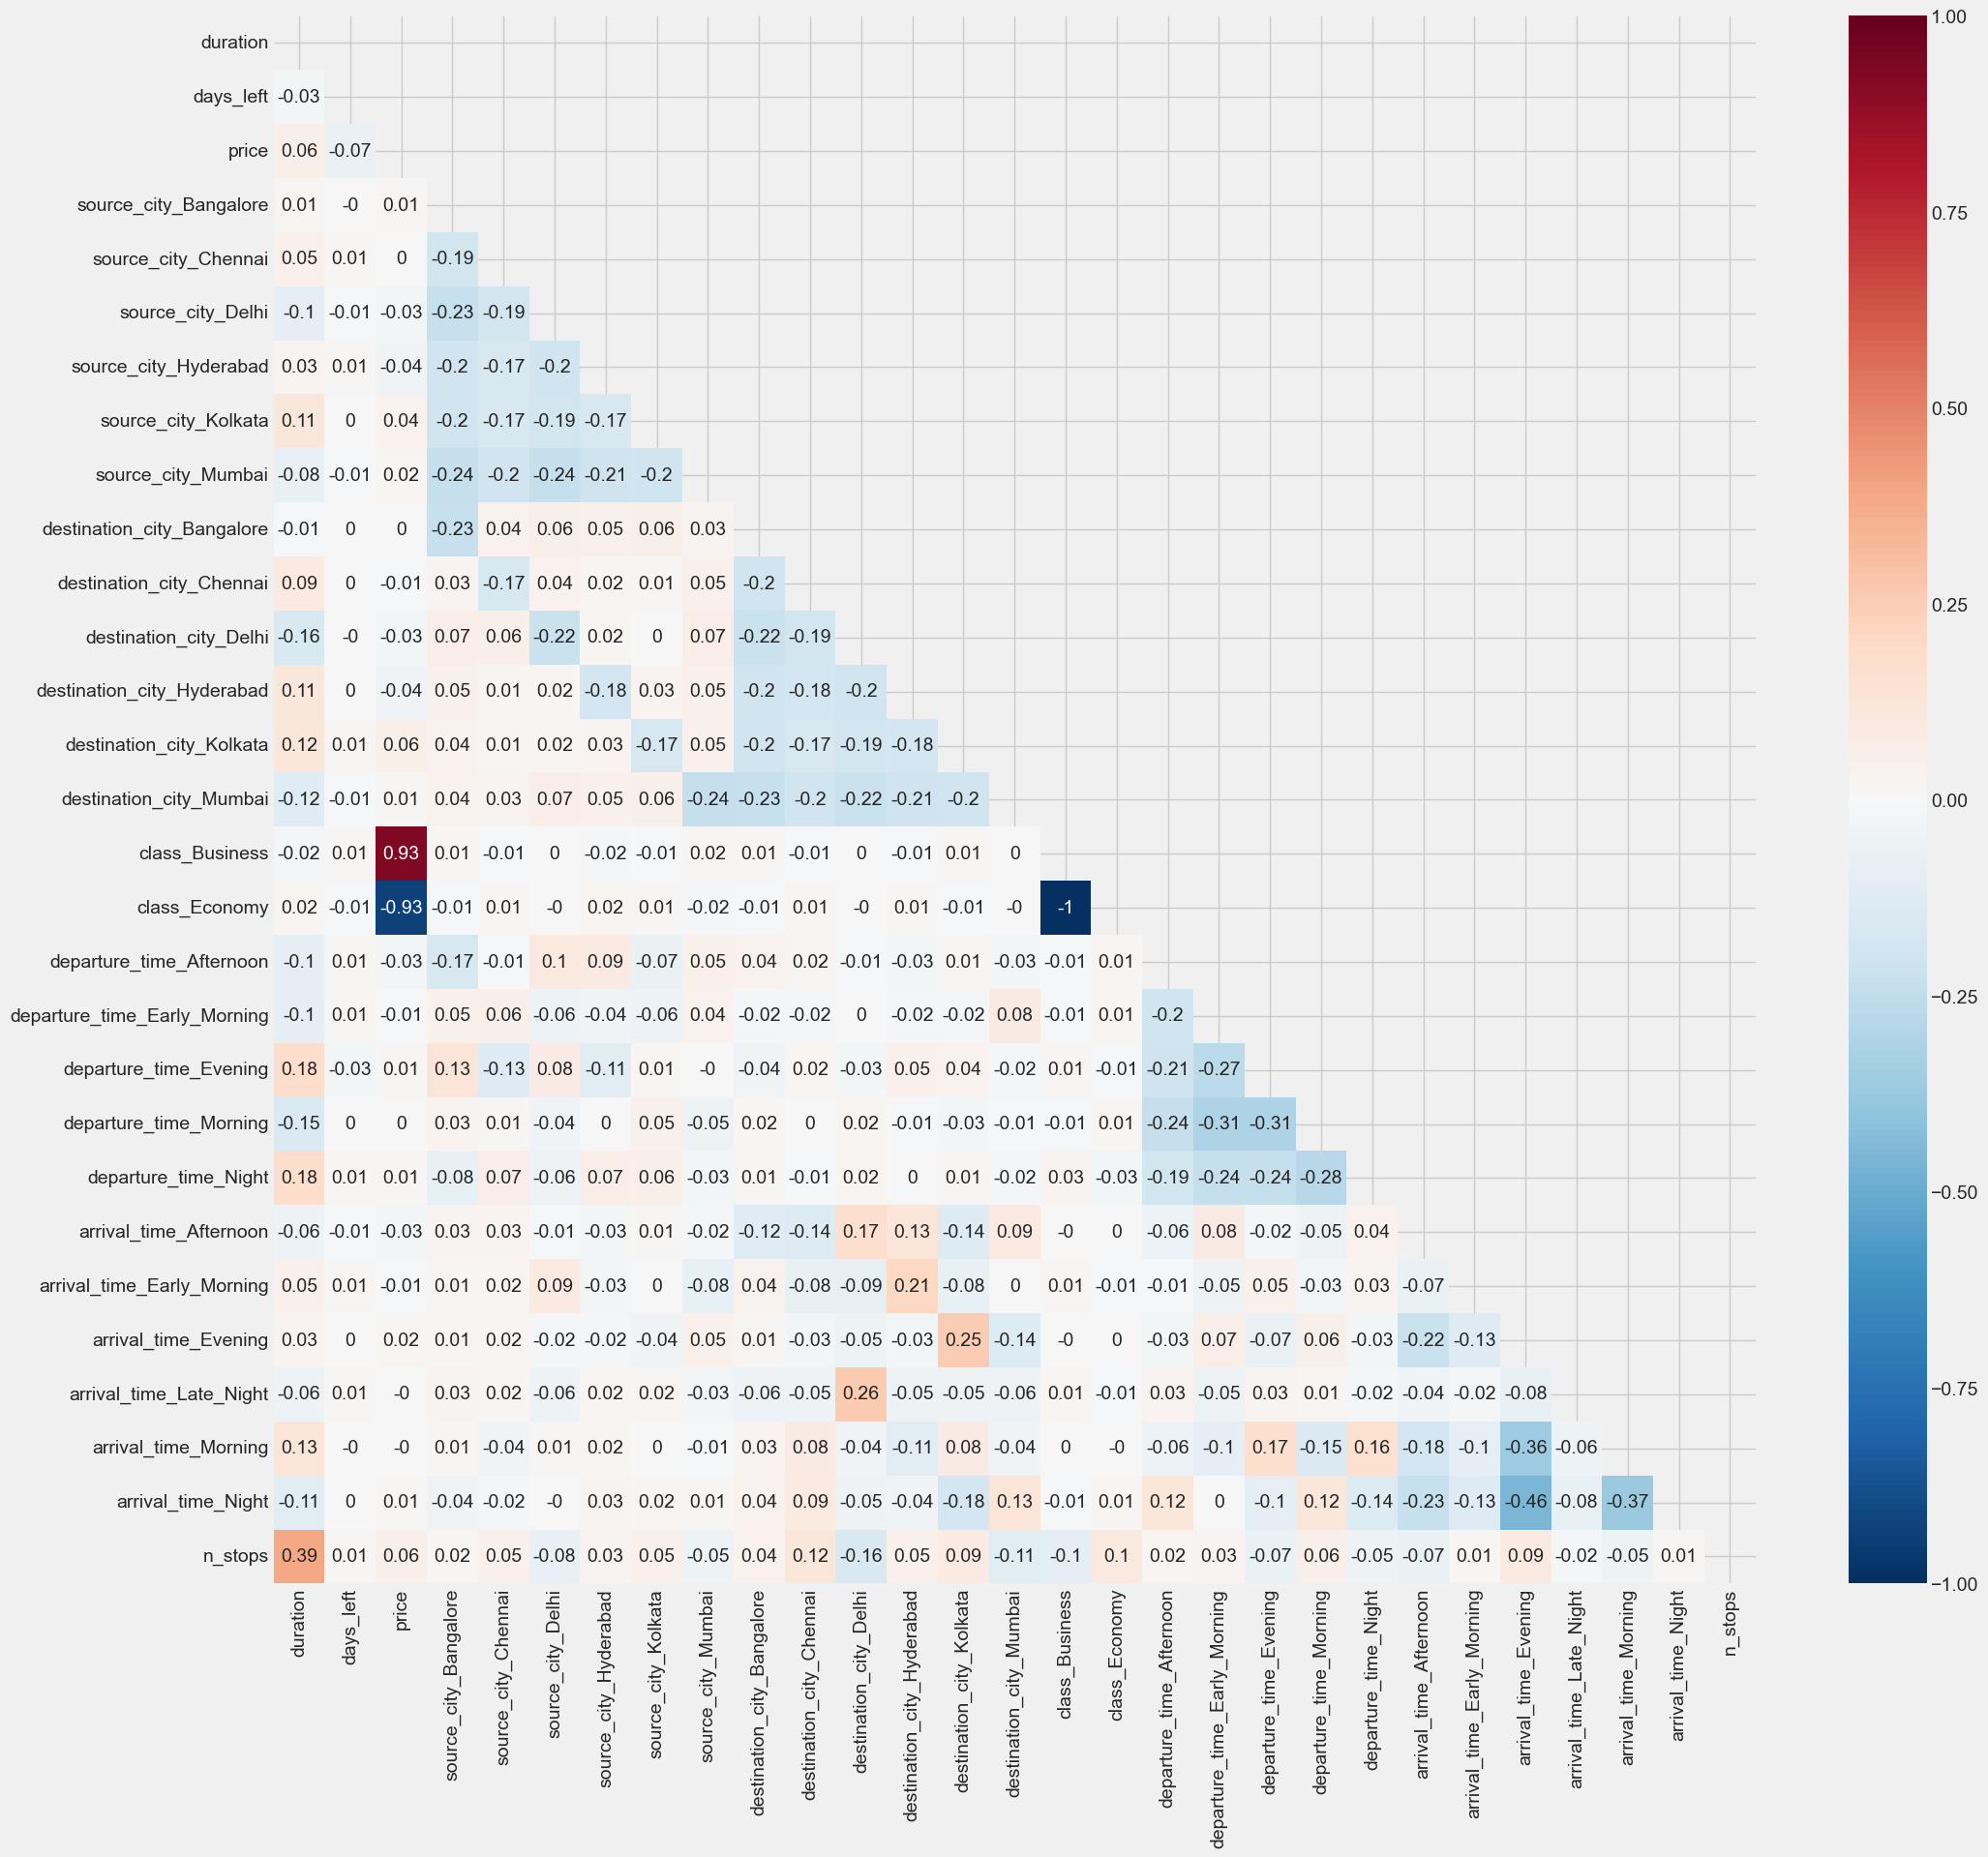

In [32]:
mask = np.triu(np.ones_like(corr, dtype=bool))

fig, ax = plt.subplots(figsize=(22,20))
g = sns.heatmap(data = round(corr,2), mask=mask,annot = True, vmin= -1.0, vmax= 1.0, center = 0, cmap = 'RdBu_r',ax =ax)
plt.show()

However, correlation is a good metric for linear relationships, but it does not highlight nonlinear ones. In that case we will use mutual information.

In [33]:
def get_mi_scores(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

In [34]:
X = enc_df.copy()
y = X.pop("price")

mi_scores = get_mi_scores(X, y)

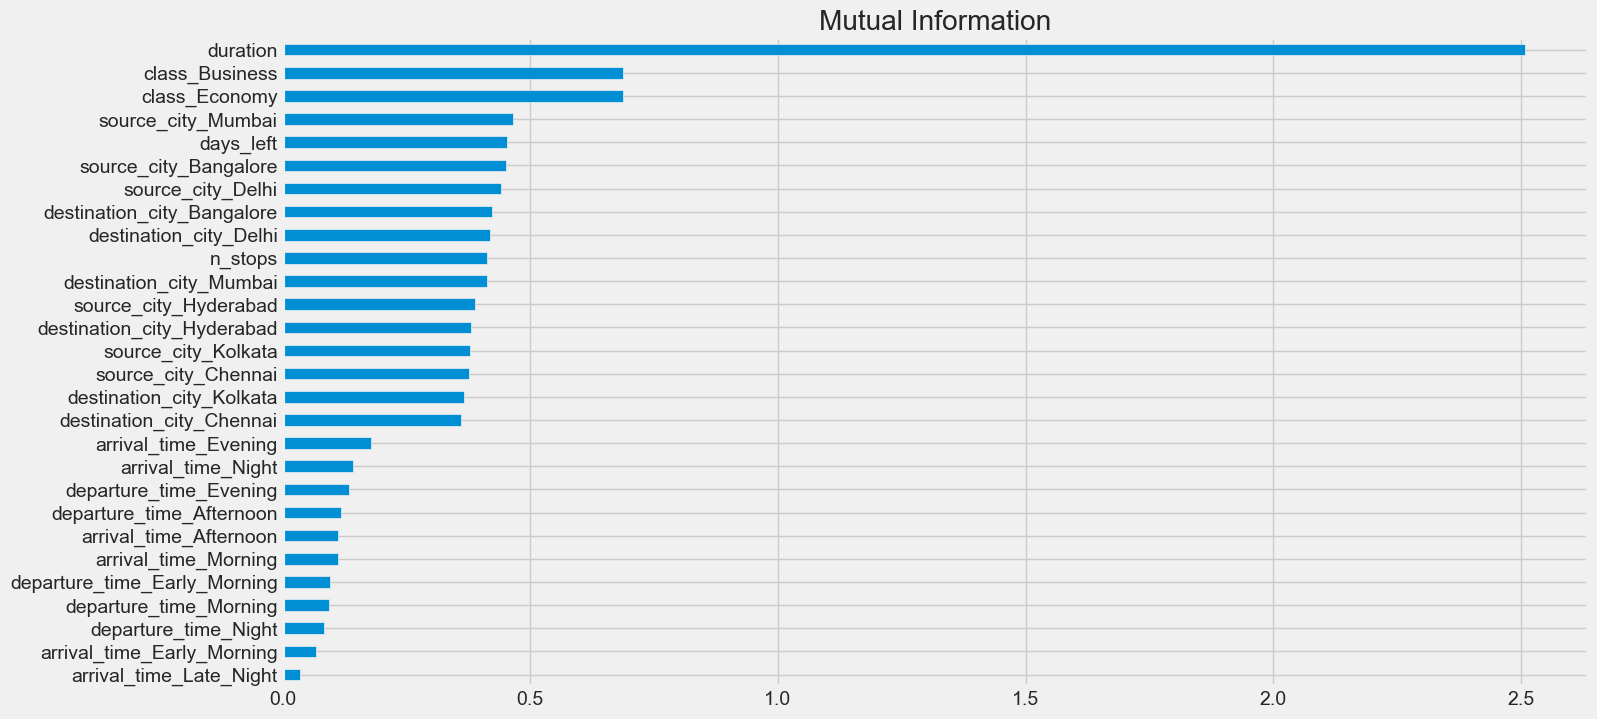

In [35]:
fig, ax = plt.subplots(figsize=(15,8))
mi_scores.sort_values().plot(kind='barh',title='Mutual Information',ax =ax)
plt.show()

>📌 When mutual information is used, a measure for non-linear relationships, we observe that the variable that most influences the price is flight duration.

## Regression Model 

Let's pick the features and target variables in our dataset

In [36]:
enc_df.columns

Index(['duration', 'days_left', 'price', 'source_city_Bangalore',
       'source_city_Chennai', 'source_city_Delhi', 'source_city_Hyderabad',
       'source_city_Kolkata', 'source_city_Mumbai',
       'destination_city_Bangalore', 'destination_city_Chennai',
       'destination_city_Delhi', 'destination_city_Hyderabad',
       'destination_city_Kolkata', 'destination_city_Mumbai', 'class_Business',
       'class_Economy', 'departure_time_Afternoon',
       'departure_time_Early_Morning', 'departure_time_Evening',
       'departure_time_Morning', 'departure_time_Night',
       'arrival_time_Afternoon', 'arrival_time_Early_Morning',
       'arrival_time_Evening', 'arrival_time_Late_Night',
       'arrival_time_Morning', 'arrival_time_Night', 'n_stops'],
      dtype='object')

In [37]:
features = ['duration', 'days_left', 'source_city_Bangalore',
       'source_city_Chennai', 'source_city_Delhi', 'source_city_Hyderabad',
       'source_city_Kolkata', 'source_city_Mumbai',
       'destination_city_Bangalore', 'destination_city_Chennai',
       'destination_city_Delhi', 'destination_city_Hyderabad',
       'destination_city_Kolkata', 'destination_city_Mumbai', 'class_Business',
       'class_Economy', 'departure_time_Afternoon',
       'departure_time_Early_Morning', 'departure_time_Evening',
       'departure_time_Morning', 'departure_time_Night',
       'arrival_time_Afternoon', 'arrival_time_Early_Morning',
       'arrival_time_Evening', 'arrival_time_Late_Night',
       'arrival_time_Morning', 'arrival_time_Night', 'n_stops']
target = 'price'

In [38]:
X = enc_df[features]
y = enc_df[target]

Let's take a look at the dimensions of X and y

In [39]:
print(f'X matrix dimensions',X.shape)
print(f'y vector dimensions',y.shape)

X matrix dimensions (127859, 28)
y vector dimensions (127859,)


We are going to perform a train-test split with 80% for training and 20% testing.  

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

### Model Parameters and Hyperparameters

To perform the ticket price estimation we will use a regressor from xgboost. This algorithm is based on the gradient boosting technique and combines multiple decision trees to improve individual predictions. It is fast, accurate and does not require variable scaling. It can handle large datasets efficiently and is applied to multiple classification and regression tasks. However it is a complex model that uses of a large amount of memory, especially for large datasets. Let's briefly explain some of its parameters:

`objective`: Loss function to minimize, in this case "reg:squarederror" for regression.

`eval_metric`: Metric used to evaluate the model during training. As we are dealing with a regression problem the root mean square error, "rmse", is considered. This metric tells us the average distance between the model's predicted values and the real values in the dataset. The lower the "rmse" the better the fit.

`n_estimators`: Number of trees to train. The more trees, the more reliable the predictions will be. If the model needs to deliver results quickly the number of trees can be limited to around 200. If the model has more time to make predictions, it could be considered using up to 5000 trees.

`learning_rate`: Controls the step size in which the optimizer performs updates to model weights. A smaller value results in slower but more accurate updates, while a larger value results in faster but less accurate updates. The recommended range for learning rate is between 0.001 and 0.1.

`max_depth`: Maximum depth to which a tree can grow. A deeper tree means more decision paths and potentially capturing more complex patterns in the data. However, increasing the depth may result in overfitting.

`subsample`: Amount of data used to build each tree. It is a fraction representing the proportion of the dataset that will be randomly selected to train each tree. By using only a portion of the data from each tree, the model can benefit from diversity and reduce correlation between trees, which can help prevent overfitting.

`colsample_bytree`: Proportion of features to consider for each tree. This value ranges from 0 to 1, where a value of 1 means that all features will be considered for each tree, and a lower value indicates that only a subset of features will be randomly chosen before building each tree.

`min_child_weight`: Minimum sum of instance weights that must be present in a child node in each tree. In regression it means the number of observations that must be present in each node. This parameter helps control the complexity of the model and prevents overfitting.

`lambda`: L2 regularization coefficient. Larger values mean a more conservative model, which helps reduce overfitting by adding a penalty term to the loss function based on the squares of the model parameters. L2 regularization helps to build smooth solutions (all parameters influence the model) and simpler models.

`alpha`: L1 regularization coefficient. Larger values mean a more conservative model, which helps reduce overfitting by adding a penalty term to the loss function based on the absolute value of the model parameters. This type of regularization helps to select features by imposing sparse solutions.

It's time to create a regression model with xgboost. An early_stopping_rounds parameter allows stopping the algorithm once there is no improvement in the metric used to evaluate performance, in this case the RMSE.

In [56]:
base_xgb = XGBRegressor(n_estimators=1000,early_stopping_rounds=40,learning_rate=0.01)

### Model Fit

Now we will fit the model we have just created to our trainig data.

In [57]:
base_xgb.fit(X_train, y_train,eval_set=[(X_train,y_train),(X_test,y_test)],verbose=50)

[0]	validation_0-rmse:25417.78743	validation_1-rmse:25324.02245
[50]	validation_0-rmse:16260.42955	validation_1-rmse:16196.53874
[100]	validation_0-rmse:11040.21606	validation_1-rmse:11003.57443
[150]	validation_0-rmse:8247.92585	validation_1-rmse:8238.75637
[200]	validation_0-rmse:6841.85916	validation_1-rmse:6856.15290
[250]	validation_0-rmse:6160.66917	validation_1-rmse:6193.33449
[300]	validation_0-rmse:5819.86648	validation_1-rmse:5866.73356
[350]	validation_0-rmse:5629.56018	validation_1-rmse:5684.88745
[400]	validation_0-rmse:5488.36142	validation_1-rmse:5550.35289
[450]	validation_0-rmse:5383.51999	validation_1-rmse:5450.64740
[500]	validation_0-rmse:5297.08905	validation_1-rmse:5369.66022
[550]	validation_0-rmse:5226.84053	validation_1-rmse:5303.14711
[600]	validation_0-rmse:5153.90146	validation_1-rmse:5232.43999
[650]	validation_0-rmse:5092.06400	validation_1-rmse:5174.85953
[700]	validation_0-rmse:5041.19524	validation_1-rmse:5127.90954
[750]	validation_0-rmse:4990.60021	va

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=40,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

Let's see the importance of each feature in the model.

In [58]:
fi = pd.DataFrame(data = base_xgb.feature_importances_,index = features,columns=['importance'])

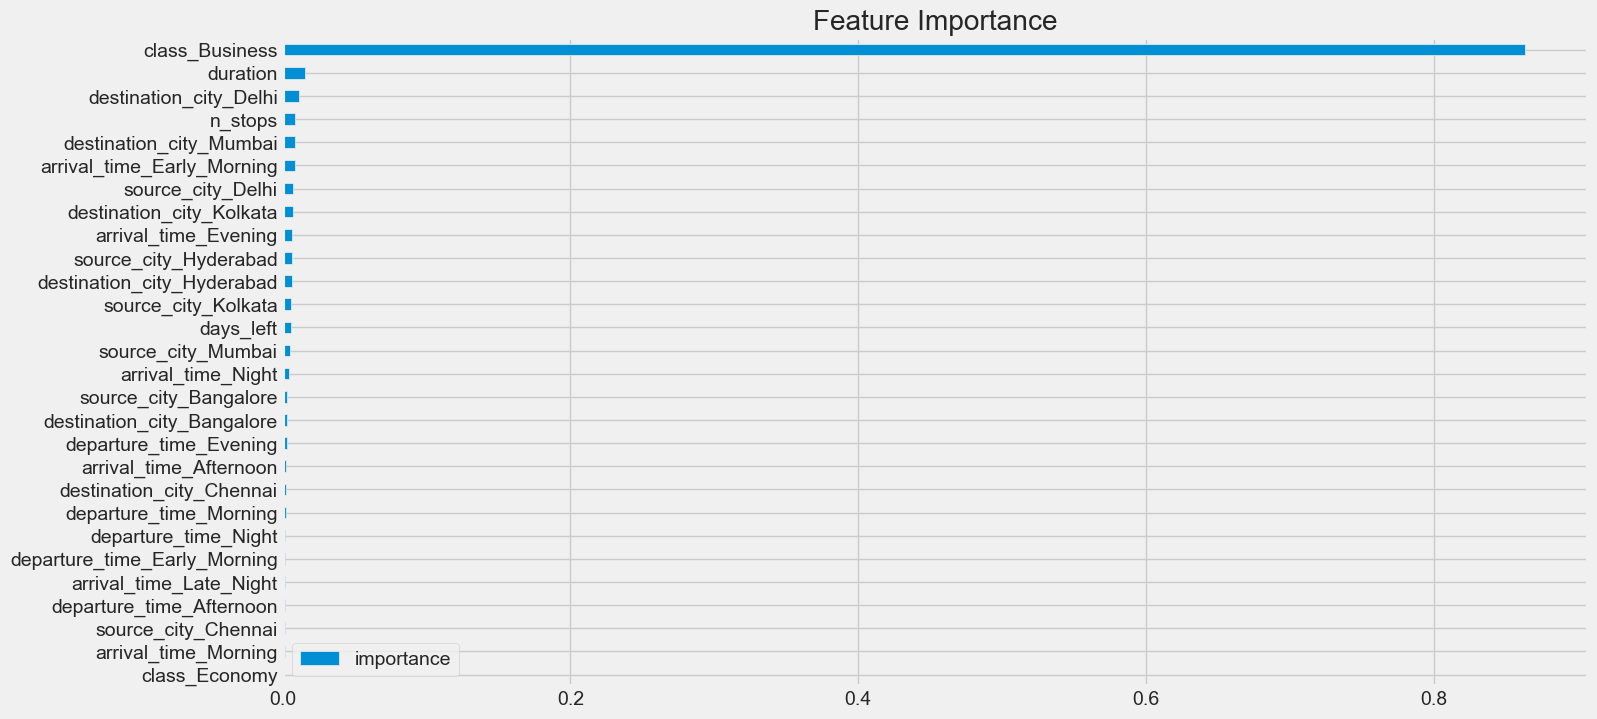

In [59]:
fig, ax = plt.subplots(figsize=(15,8))
fi.sort_values('importance').plot(kind='barh',title='Feature Importance',ax = ax)
plt.show()

Whoa! Business class is ,by far, the main determinant when estimating ticket price.

### Model Evaluation

Let us now observe the learning curve for our model. This helps identifying overfitting or underfitting.

In [60]:
results = base_xgb.evals_result()
results_training = results['validation_0']['rmse']
results_test = results['validation_1']['rmse']
results_df = pd.concat([pd.DataFrame(results_training,columns=['Training']),pd.DataFrame(results_test,columns=['Testing']) ],axis=1)

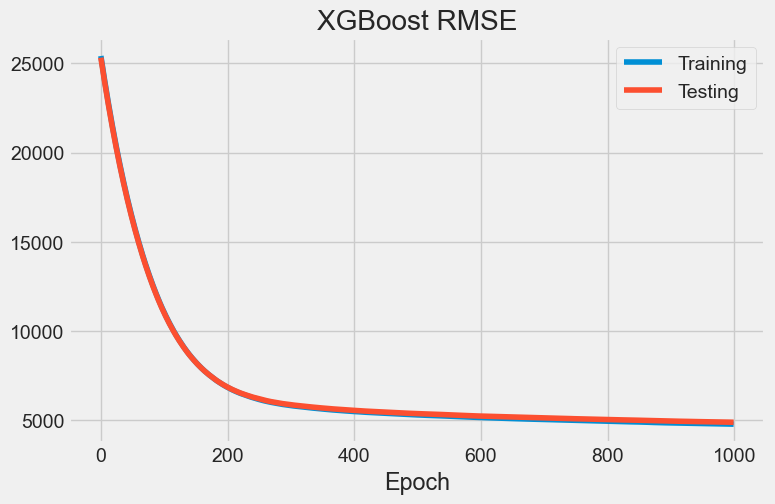

In [61]:
fig, ax = plt.subplots(figsize=(8, 5))
results_df['Training'].plot(ax=ax, title = 'XGBoost RMSE',label='Training')
results_df['Testing'].plot(ax=ax, label='Testing')
ax.legend(['Training','Testing'])
ax.set_xlabel('Epoch')
plt.show()

In [62]:
print('RMSE in Training Set:',round(results_df['Training'].min()) )
print('RMSE in Testing Set:', round(results_df['Testing'].min()))

RMSE in Training Set: 4779
RMSE in Testing Set: 4885


>📌 The learning curve shows a good fit with low training and testing errors.

Now let's graph the real price versus the value predicted by the model.

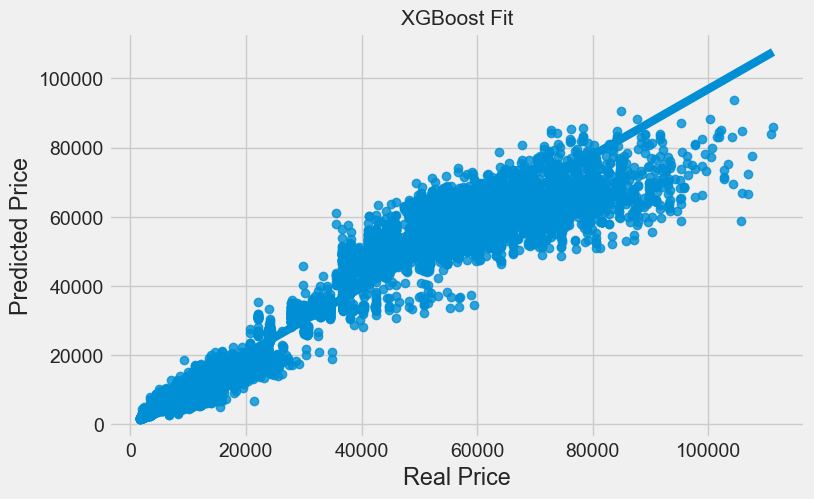

In [63]:
y_pred = base_xgb.predict(X_test)

fig, ax = plt.subplots(figsize=(8, 5))
g = sns.regplot(x=y_test, y=y_pred, fit_reg=True, ax = ax)
g.set_title('XGBoost Fit',fontsize=15)
g.set_xlabel('Real Price')
g.set_ylabel('Predicted Price')
plt.show()

To measure the goodness of fit let's look at the determination coefficient or R-squared. The closer it is to 1, the better the fit.

In [64]:
print('Determination coefficient in Training:', round(base_xgb.score(X_train, y_train)*100,2))
print('Determination coefficient in Testing:', round(base_xgb.score(X_test, y_test)*100,2))

Determination coefficient in Training: 96.53
Determination coefficient in Testing: 96.35


## Model Fine-Tuning

To improve the results obtained by the model we can adjust its hyperparameters using the Optuna library. Optuna uses a Bayesian optimization technique to find the best model hyperparameters. This approach models the behavior of the objective function and guides the search for optimal hyperparameter values, by updating the probability density functions based on the results of previous tests.

### Hyperparameter Optimization

First, we must define all the model hyperparameters that we are going to tweak and its search space.

In [65]:
def objective(trial):
         
    params = {
        "early_stopping_rounds":40,
        "objective": "reg:squarederror",
        "n_estimators": trial.suggest_int("n_estimators", 200, 1000),
        "verbosity": 0,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "max_depth": trial.suggest_int("max_depth", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 20),
        "alpha": trial.suggest_float("alpha", 0.01, 10.0,log=True),
        "lambda": trial.suggest_float("lambda", 1e-8, 10.0,log=True),
    }

    model = XGBRegressor(**params)
    model.fit(X_train, y_train,eval_set=[(X_train,y_train),(X_test,y_test)], verbose=False)
    predictions = model.predict(X_test)
    rmse = mean_squared_error(y_test, predictions, squared=False)
    return rmse

Next we execute the search using 30 iterations, which should be enough to find optimal values.

In [66]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)

[I 2024-01-18 11:24:07,666] A new study created in memory with name: no-name-a0bf8e99-6a68-4ace-ae56-9b2bd2189db7
[I 2024-01-18 11:24:12,452] Trial 0 finished with value: 14847.805377149796 and parameters: {'n_estimators': 506, 'learning_rate': 0.0016202453306040146, 'max_depth': 7, 'subsample': 0.9480498917075619, 'colsample_bytree': 0.5095456763263811, 'min_child_weight': 10, 'alpha': 1.0194800438569804, 'lambda': 1.9698502960112642e-05}. Best is trial 0 with value: 14847.805377149796.
[I 2024-01-18 11:24:20,423] Trial 1 finished with value: 5145.194346872688 and parameters: {'n_estimators': 917, 'learning_rate': 0.012457706395303721, 'max_depth': 5, 'subsample': 0.20787783832425266, 'colsample_bytree': 0.8060597887630879, 'min_child_weight': 17, 'alpha': 2.3848298744994456, 'lambda': 7.268961431170135e-06}. Best is trial 1 with value: 5145.194346872688.
[I 2024-01-18 11:24:25,196] Trial 2 finished with value: 6807.86806611022 and parameters: {'n_estimators': 610, 'learning_rate': 0.

[I 2024-01-18 11:26:02,320] Trial 22 finished with value: 3197.2130115904843 and parameters: {'n_estimators': 668, 'learning_rate': 0.09955771469596542, 'max_depth': 8, 'subsample': 0.8960154043911981, 'colsample_bytree': 0.5967226179153364, 'min_child_weight': 3, 'alpha': 0.3467670889352218, 'lambda': 0.06887684312720231}. Best is trial 22 with value: 3197.2130115904843.
[I 2024-01-18 11:26:09,572] Trial 23 finished with value: 3327.55690024182 and parameters: {'n_estimators': 652, 'learning_rate': 0.052593894470227526, 'max_depth': 8, 'subsample': 0.7326692692690475, 'colsample_bytree': 0.7821224244492353, 'min_child_weight': 1, 'alpha': 0.01950654897489639, 'lambda': 0.13924035007173785}. Best is trial 22 with value: 3197.2130115904843.
[I 2024-01-18 11:26:16,347] Trial 24 finished with value: 3293.7939664675605 and parameters: {'n_estimators': 651, 'learning_rate': 0.049374910713985885, 'max_depth': 8, 'subsample': 0.8606751156666513, 'colsample_bytree': 0.837828145594756, 'min_chi

In [67]:
print('Best Parameters:', study.best_params)
print('Best RMSE:', study.best_value)

Best Parameters: {'n_estimators': 668, 'learning_rate': 0.09955771469596542, 'max_depth': 8, 'subsample': 0.8960154043911981, 'colsample_bytree': 0.5967226179153364, 'min_child_weight': 3, 'alpha': 0.3467670889352218, 'lambda': 0.06887684312720231}
Best RMSE: 3197.2130115904843


Now we can visualize the importance of each parameter and hyperparameter in our model.

In [68]:
optuna.visualization.plot_param_importances(study)

>📌 The learning rate is the most important parameter influencing the performance of the model.

We can also visualize how the objective function behaves in each trial.

In [69]:
optuna.visualization.plot_optimization_history(study)

After approximately 4 iterations the objective function does not vary significantly, which shows that the method quickly finds the optimal hyperparameters. Let's now train the XGBoost regression model using these parameters.

In [70]:
tuned_xgb = XGBRegressor(**study.best_params)

tuned_xgb.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test,y_test)],verbose=50)

[0]	validation_0-rmse:23273.82646	validation_1-rmse:23183.96445
[50]	validation_0-rmse:4713.31362	validation_1-rmse:4848.88811
[100]	validation_0-rmse:4065.56688	validation_1-rmse:4288.17136
[150]	validation_0-rmse:3748.74523	validation_1-rmse:4023.68954
[200]	validation_0-rmse:3466.72548	validation_1-rmse:3791.91506
[250]	validation_0-rmse:3263.75155	validation_1-rmse:3634.54882
[300]	validation_0-rmse:3092.00559	validation_1-rmse:3528.59263
[350]	validation_0-rmse:2970.03122	validation_1-rmse:3445.06548
[400]	validation_0-rmse:2866.24899	validation_1-rmse:3383.56278
[450]	validation_0-rmse:2767.99682	validation_1-rmse:3320.45102
[500]	validation_0-rmse:2697.02720	validation_1-rmse:3280.71407
[550]	validation_0-rmse:2631.63233	validation_1-rmse:3249.99097
[600]	validation_0-rmse:2571.48647	validation_1-rmse:3223.04166
[650]	validation_0-rmse:2521.05132	validation_1-rmse:3201.94043
[667]	validation_0-rmse:2504.40841	validation_1-rmse:3197.21301


XGBRegressor(alpha=0.3467670889352218, base_score=None, booster=None,
             callbacks=None, colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.5967226179153364, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             lambda=0.06887684312720231, learning_rate=0.09955771469596542,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=3, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=668, n_jobs=None, ...)

Again, let's take a look at the learning curves.

In [71]:
results = tuned_xgb.evals_result()
results_training = results['validation_0']['rmse']
results_test = results['validation_1']['rmse']
results_df = pd.concat([pd.DataFrame(results_training,columns=['Training']),pd.DataFrame(results_test,columns=['Testing']) ],axis=1)

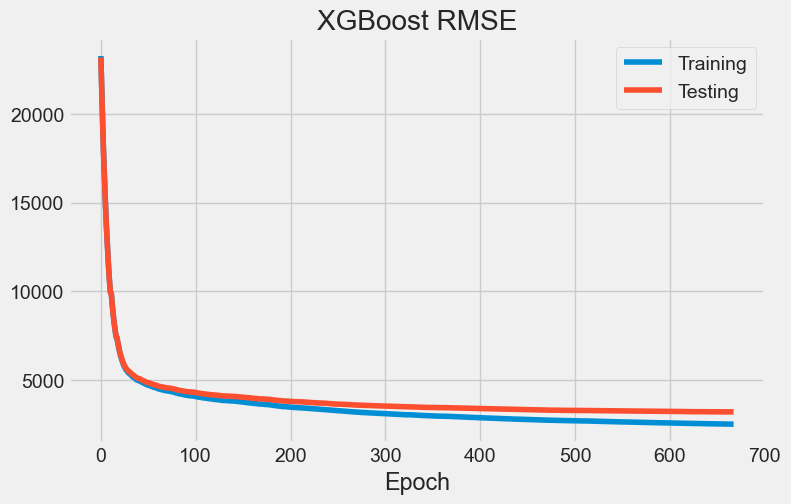

In [72]:
fig, ax = plt.subplots(figsize=(8, 5))
results_df['Training'].plot(ax=ax, title = 'XGBoost RMSE',label='Training')
results_df['Testing'].plot(ax=ax, label='Testing')
ax.legend(['Training','Testing'])
ax.set_xlabel('Epoch')
plt.show()

In [73]:
print('RMSE in Training Set:',round(results_df['Training'].min()) )
print('RMSE in Testing Set:', round(results_df['Testing'].min()))

RMSE in Training Set: 2504
RMSE in Testing Set: 3197


The optimization of hyperparameters improved the RMSE. However, we must pay attention to testing error as it begins to exceed training error which can lead to overfitting. 

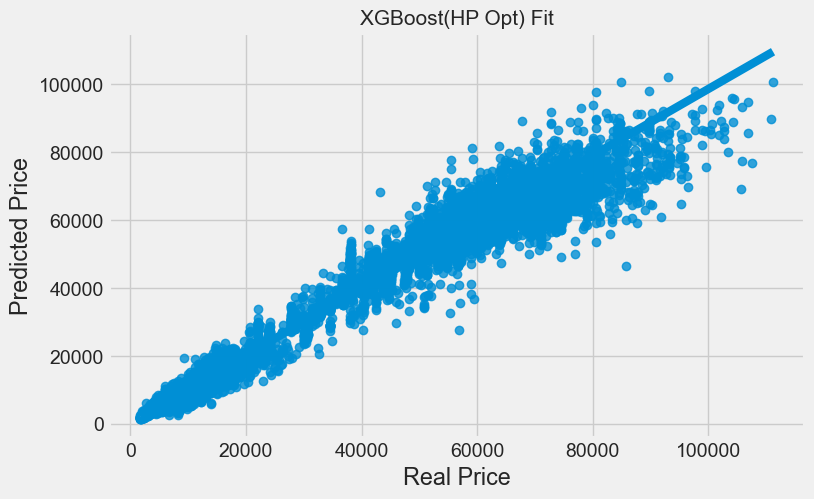

In [74]:
y_pred = tuned_xgb.predict(X_test)

fig, ax = plt.subplots(figsize=(8, 5))
g = sns.regplot(x=y_test, y=y_pred, fit_reg=True, ax = ax)
g.set_title('XGBoost(HP Opt) Fit',fontsize=15)
g.set_xlabel('Real Price')
g.set_ylabel('Predicted Price')
plt.show()

Let's look at the determination coefficient.

In [75]:
print('Determination coefficient in Training:', round(tuned_xgb.score(X_train, y_train)*100,2))
print('Determination coefficient in Testing:', round(tuned_xgb.score(X_test, y_test)*100,2))

Determination coefficient in Training: 99.05
Determination coefficient in Testing: 98.44


### Saving the Model

Once we have fine-tuned our model we can save it as a json file using the save_model function

In [73]:
tuned_xgb.save_model('xgb_model.json')

Another way to save the model is to use the dump method from joblib. This is more efficient on objects containing large arrays, making it suitable for saving and loading models like XGBoost.

In [76]:
joblib.dump(tuned_xgb,'xgb_model.pkl')

['xgb_model.pkl']